In [3]:
import pandas as pd

# Read the data into a DataFrame'
df = pd.read_csv("../../data/raw/sales_train.csv")
df_test = pd.read_csv("../../data/raw/sales_test.csv")

In [4]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,0,1,0,1,0,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,8,2,0,8,2,3,1,1,3,8
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,0,1,3,2,1,1,2,2,3


In [5]:
df.shape

(30490, 1547)

In [6]:
df.drop(["id", "dept_id", "cat_id", "state_id"], inplace=True, axis=1)

In [7]:
df = df.melt(id_vars=['item_id', 'store_id'], var_name='d', value_name='units_sold')

In [8]:
df.head()

,item_id,store_id,d,units_sold
0,HOBBIES_1_001,CA_1,d_1,0
1,HOBBIES_1_002,CA_1,d_1,0
2,HOBBIES_1_003,CA_1,d_1,0
3,HOBBIES_1_004,CA_1,d_1,0
4,HOBBIES_1_005,CA_1,d_1,0


In [9]:
df.shape

(46985090, 4)

In [2]:
import sys
sys.path.append('../../src/data')

from merge import Merger
df_merged = Merger().merge_df(df)

In [14]:
df_merged.head()

,item_id,store_id,date,sell_price,revenue
0,HOBBIES_1_008,CA_1,2011-01-29,0.46,5.52
1,HOBBIES_1_008,CA_1,2011-01-30,0.46,6.90
2,HOBBIES_1_008,CA_1,2011-01-31,0.46,0.00
3,HOBBIES_1_008,CA_1,2011-02-01,0.46,0.00
4,HOBBIES_1_008,CA_1,2011-02-02,0.46,0.00


In [15]:
del df

In [16]:
df_merged.shape

(34720691, 5)

In [17]:
df_cleaned = df_merged.groupby('date')['revenue'].sum().reset_index()

In [18]:
df_cleaned.head()

,date,revenue
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95


## Check for outliers

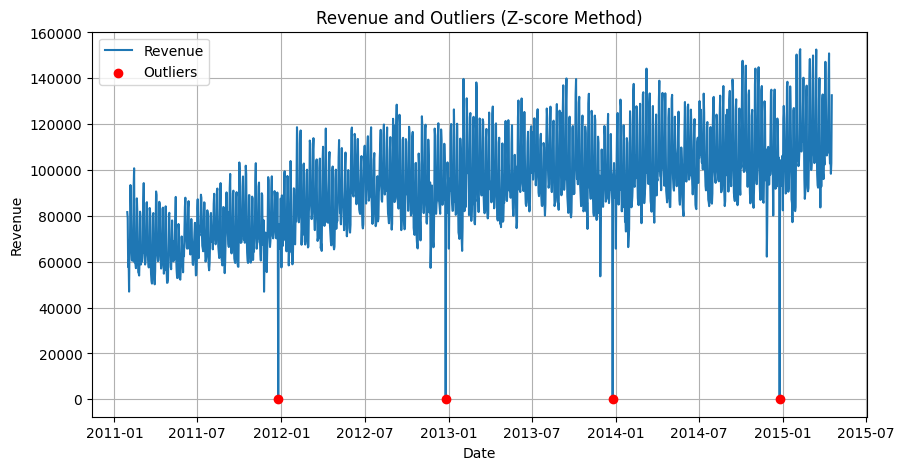

In [19]:
from scipy import stats
import matplotlib.pyplot as plt

# Calculate Z-scores for the 'revenue' column
z_scores = stats.zscore(df_cleaned['revenue'])

# Define a Z-score threshold to identify outliers
z_score_threshold = 3  # You can adjust this threshold as needed

# Identify outliers based on the Z-score
outliers = df_cleaned[abs(z_scores) > z_score_threshold]

# Create a plot of outliers
plt.figure(figsize=(10, 5))
plt.plot(df_cleaned['date'], df_cleaned['revenue'], label='Revenue')
plt.scatter(outliers['date'], outliers['revenue'], color='red', marker='o', label='Outliers', zorder=5)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue and Outliers (Z-score Method)')
plt.legend()
plt.grid()
plt.show()

In [20]:
df_cleaned = df_cleaned[abs(z_scores) <= z_score_threshold]

In [21]:
df_cleaned.shape

(1537, 2)

In [22]:
(df_cleaned[df_cleaned['revenue'] == 0]['date']).any()

False

No zero sales for any date present in the data. Good!

## Modelling

In [23]:
# Import necessary libraries
import os
import glob
import pickle
import warnings
import numpy as np
import seaborn as sns
from numpy import mean, std
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Set 'date' as the index
df_cleaned.set_index('date', inplace=True)

## Baseline Model - EWM

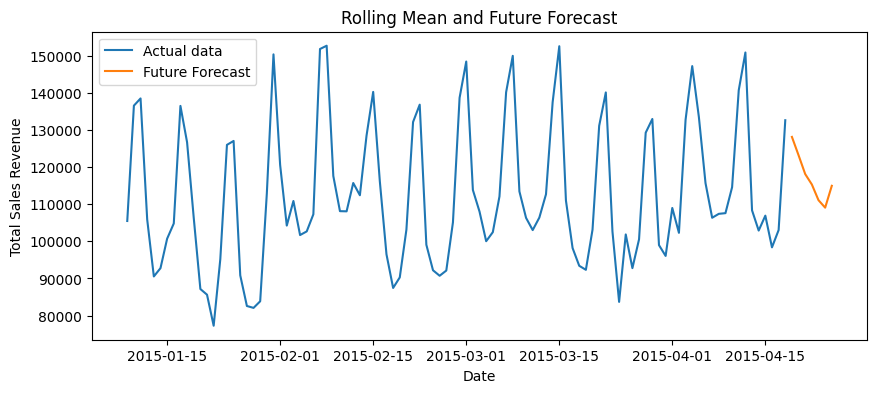

In [25]:
# Calculate the rolling mean with a window size of 1 year (for 365 days)
pred_ewm = df_cleaned['revenue'].ewm(span=7, adjust=False).mean()

# Use the rolling mean to predict future values for the next year
last_date = df_cleaned.index[-1]
next_year = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=7, freq='D')

# save the forecast into a pandas series for visualization
future_forecast = pd.Series(pred_ewm[-7:].values, index=next_year[:7])

# Plot the rolling mean and future forecast
plt.figure(figsize=(10, 4))
plt.plot(df_cleaned["revenue"].tail(100), label='Actual data')
plt.plot(future_forecast, label='Future Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales Revenue')
plt.title('Rolling Mean and Future Forecast')
plt.legend(loc='best')
plt.show()


In [26]:
future_forecast

2015-04-19    128132.728006
2015-04-20    123185.761004
2015-04-21    118113.550753
2015-04-22    115313.633065
2015-04-23    111078.597299
2015-04-24    109066.592974
2015-04-25    114956.417231
Freq: D, dtype: float64

In [27]:
# importing means squared error metrics package from sklearn
from sklearn.metrics import mean_squared_error

#Taking 20% of the data for testing
rmse_ewma = np.sqrt(mean_squared_error(df_cleaned["revenue"][1230:], pred_ewm[1230:]))
print("RMSE for Exponential Weighted Moving Average on test data:", rmse_ewma)

RMSE for Exponential Weighted Moving Average on test data: 13932.373440208878


## ARIMA model

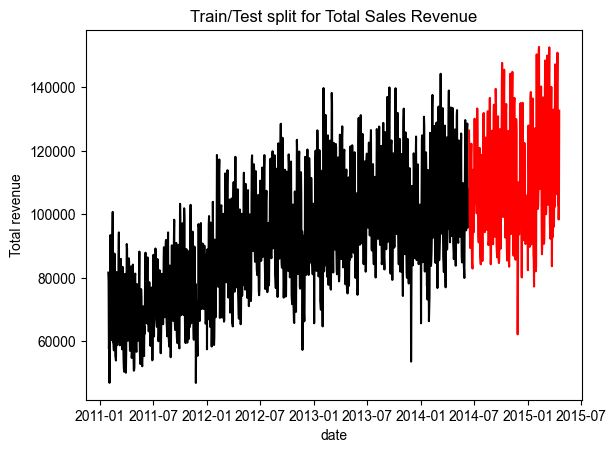

In [28]:
# Split the data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(df_cleaned) * 0.80)
train_data, test_data = df_cleaned.iloc[:train_size], df_cleaned.iloc[train_size:]

#Plot train and test sets
plt.plot(train_data["revenue"], color = "black")
plt.plot(test_data["revenue"], color = "red")
plt.title("Train/Test split for Total Sales Revenue")
plt.ylabel("Total revenue")
plt.xlabel('date')
sns.set()
plt.show()

In [44]:
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.compose import TransformedTargetRegressor

model_arima = auto_arima(train_data["revenue"], trace=True, error_action='ignore', suppress_warnings=True)
model_fit_arima = model_arima.fit(train_data["revenue"])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26222.905, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27015.631, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26982.942, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26943.569, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27013.634, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26376.160, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=26191.837, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26359.310, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=25659.635, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=26161.635, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=25572.344, Time=1.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=25758.702, Time=0.31 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=25555.061, Time=1.17 sec
 ARIMA(4,1,3)(0,0,0)[0] i

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Root Mean Squared Error (RMSE): 14852.505729845623


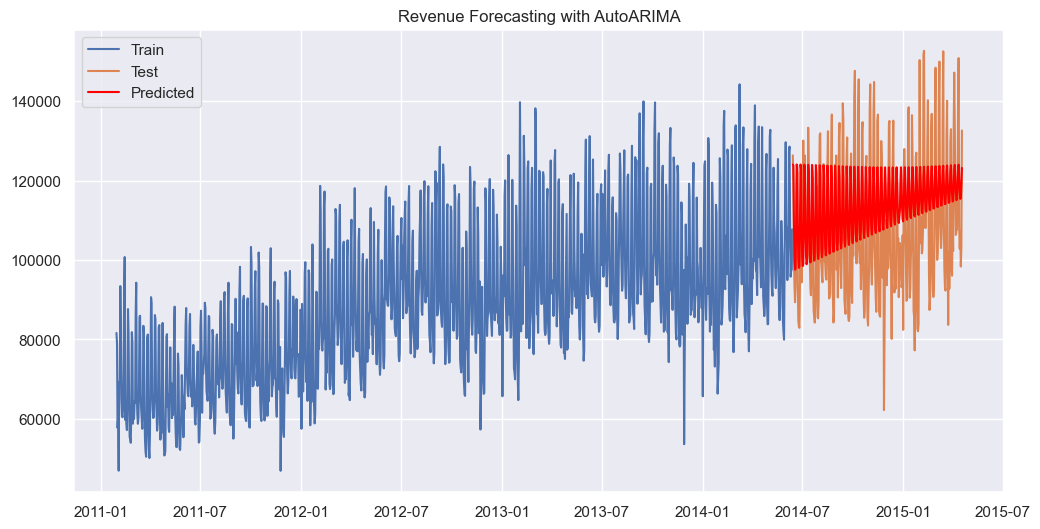

In [46]:
# Evaluate the model on the testing data
predictions = model_fit_arima.predict(n_periods=len(test_data))
rmse_arima = np.sqrt(mean_squared_error(test_data['revenue'], predictions))
print("Root Mean Squared Error (RMSE):", rmse_arima)

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['revenue'], label='Train')
plt.plot(test_data.index, test_data['revenue'], label='Test')
plt.plot(test_data.index, predictions, label='Predicted', color='red')
plt.legend(loc='best')
plt.title('Revenue Forecasting with AutoARIMA')
plt.show()

In [47]:
# Predict the next 7 days' revenue based on an input date
input_date = pd.to_datetime('2023-09-01')  # Replace with your input date
forecast_steps = 7
forecast_index = pd.date_range(start=input_date, periods=forecast_steps)
forecast = model_fit_arima.predict(forecast_index)

# Print the next 7 days' revenue forecast
print("Next 7 Days' Revenue Forecast:")
print(forecast)


TypeError: n_periods must be an int

## SARIMAX model

In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


# Custom transformer to perform seasonal decomposition
class SeasonalDecomposer(BaseEstimator, TransformerMixin):
    def __init__(self, freq=7):
        self.freq = freq
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        decomposition = seasonal_decompose(X['revenue'], model='additive', freq=self.freq)
        X['trend'] = decomposition.trend
        X['seasonal'] = decomposition.seasonal
        X['residual'] = decomposition.resid
        return X

# Define the SARIMA model
class SARIMAModel(BaseEstimator, TransformerMixin):
    def __init__(self, order=(1, 0, 0), seasonal_order=(1, 1, 1, 7)):
        self.order = order
        self.seasonal_order = seasonal_order
    
    def fit(self, X, y=None):
        self.model = SARIMAX(X['revenue'],
                             order=self.order,
                             seasonal_order=self.seasonal_order,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
        self.results = self.model.fit()
        return self
    
    def transform(self, X):
        return X
    
    def predict(self, X):
        predictions = self.results.get_forecast(steps=len(X))
        return predictions.predicted_mean

# Create a pipeline
pipeline = Pipeline([
    ('decomposer', SeasonalDecomposer(freq=7)),
    ('sarima', SARIMAModel(order=(1, 0, 0), seasonal_order=(1, 1, 1, 7)))
])

# Fit the pipeline on training data
pipeline.fit(train_data)

In [ ]:
# Make predictions on the testing data
sarima_predictions = pipeline.predict(test_data)

# Evaluate the SARIMA model
rmse = np.sqrt(mean_squared_error(test_data['revenue'], sarima_predictions))
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['revenue'], label='Train')
plt.plot(test_data.index, test_data['revenue'], label='Test')
plt.plot(test_data.index, sarima_predictions, label='Predicted', color='red')
plt.legend(loc='best')
plt.title('Revenue Forecasting with SARIMA')
plt.show()


In [93]:
# Now you can use the pipeline for prediction
# Predict the next 7 days' revenue based on an input date
input_date = pd.to_datetime('2023-09-01')  # Replace with your input date
forecast = pipeline.forecast(steps=7, initial=input_date)

# Print the next 7 days' revenue forecast
print("Next 7 Days' Revenue Forecast:")
print(forecast)

## Appendix

In [ ]:
# Hyperparameter grid for grid search
param_grid = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
    'regressor__max_iter': [1000, 5000, 10000],
}

# Grid search with cross-validation
#cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Use KFold for regression
grid_search = GridSearchCV(
    pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X, y)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Fit the model with the best hyperparameters
final_pipeline = grid_search.best_estimator_
final_pipeline.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the test set
y_pred = final_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

In [ ]:
# Build an EMA forecasting model
model = ExponentialSmoothing(train_data['revenue'], trend='add', seasonal='add', seasonal_periods=7)
ema_model = model.fit()

# Evaluate the model on the testing data
predictions = ema_model.forecast(len(test_data))
mse = mean_squared_error(test_data['revenue'], predictions)
print("Mean Squared Error (MSE):", mse)

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['revenue'], label='Train')
plt.plot(test_data.index, test_data['revenue'], label='Test')
plt.plot(test_data.index, predictions, label='Predicted', color='red')
plt.legend(loc='best')
plt.title('Revenue Forecasting with EMA')
plt.show()

# Predict the next 7 days' revenue based on an input date
input_date = pd.to_datetime('2023-09-01')  # Replace with your input date
forecast = ema_model.forecast(steps=7, initial=input_date)

# Print the next 7 days' revenue forecast
print("Next 7 Days' Revenue Forecast:")
print(forecast)